In [8]:
import copy

import dot_magic

from Syntax import *
from Causal import *

#  Kernel of Causal ordering

  - termination: $ker(0) = \emptyset$

In [9]:
def _term_kernel_order(term):
    return CausalOrder()

Term.kernel_order = _term_kernel_order

In [10]:
Term().causal_order().view()

 - prefixing $ker(\alpha.P) = ker(P)$

In [11]:
def _prefix_kernel_order(prefix):
    cont_order = prefix.cont.kernel_order()
    #sync_srcs = set()
    #for src in cont_order.sources:
    #    if src.startswith('sync'):
    #        sync_srcs.add(src)
        
    #if sync_srcs:
    #    cont_order.vertices.add(prefix.act)
    #    cont_order.out_edges[prefix.act] = set()
    #    cont_order.in_edges[prefix.act] = set()
    #    for sync_src in sync_srcs:
    #        cont_order.out_edges[prefix.act].add(sync_src)
    #        cont_order.in_edges[sync_src].add(prefix.act)
    
    # cont_order.prefix(prefix.act)
    return cont_order

Prefix.kernel_order = _prefix_kernel_order

In [12]:
Prefix('a', Term()).kernel_order().view()

  - parallel : $ker(P\parallel Q) = ker(P) \cup ker(Q)$

In [13]:
def _parallel_kernel_order(parallel):
    left_order = parallel.left.kernel_order()
    right_order = parallel.right.kernel_order()
    left_order.extend(right_order)
    return left_order

Parallel.kernel_order = _parallel_kernel_order

  - synchronization: $ker\left((\nu B)P\right) = ker(P)$  

In [14]:
def _barrier_kernel_order(bar_proc):
    order = bar_proc.proc.kernel_order()

    # XXX : no join to perform here ...
    return order

Barrier.kernel_order = _barrier_kernel_order

  - barrier: $ker\left(\langle B \rangle P  \right)= \langle B \rangle \prec ker(P)$

In [15]:
def _synchro_kernel_order(sync_proc):
    cont_order = sync_proc.proc.kernel_order()
    cont_order.prefix('sync{}'.format(sync_proc.barrier))
    return cont_order

Synchro.kernel_order = _synchro_kernel_order

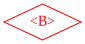

In [16]:
Prefix('a', Synchro('B', Term())).kernel_order().view()

In [17]:
proc1 = Barrier('B', Prefix('fork', 
            par(Prefix('start1', Prefix('end1', Synchro('B', Term()))),
                Prefix('start2', Synchro('B', Prefix('end2', Term()))),
                Synchro('B', Prefix('start3', Prefix('end3', Term()))))))
print(proc1)

nu(B)[fork.((start1.end1.<B>0 || start2.<B>end2.0) || <B>start3.end3.0)]


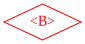

In [18]:
order = proc1.kernel_order()
order.view()

In [19]:
proc2 = Barrier('A', Barrier('B'
        ,par(Prefix('a1', Synchro('A', Prefix('a2', Term())))
             ,Synchro('B', Prefix('b', Term()))
             ,Synchro('B', Synchro('A', Prefix('c', Term()))))))
print(proc2)

nu(A)[nu(B)[((a1.<A>a2.0 || <B>b.0) || <B><A>c.0)]]


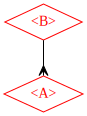

In [20]:
order = proc2.kernel_order()
order.view()

A tree :

In [21]:
tree = Prefix('a', par(Prefix('b', Prefix('c', Term())),
                       Prefix('d', Parallel(Prefix('e', Term()),
                                            Prefix('f', Prefix('g', Term())))),
                       Prefix('h', Term())))
print(tree)

a.((b.c.0 || d.(e.0 || f.g.0)) || h.0)


In [22]:
tree.kernel_order().view()

A Join :

In [23]:
join_proc = Barrier('B', par(Prefix('a', Synchro('B', Term())),
                             Prefix('b', Synchro('B', Term())),
                             Prefix('c', Synchro('B', Prefix('j', Term())))))
print(join_proc)

nu(B)[((a.<B>0 || b.<B>0) || c.<B>j.0)]


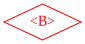

In [24]:
order = join_proc.kernel_order()
order.view()

The famous *N* :

In [25]:
n_proc = Barrier('B', Parallel(Prefix('a', Parallel(Synchro('B', Term()),
                                                    Prefix('b', Term()))),
                               Prefix('c', Synchro('B', Prefix('d', Term())))))
print(n_proc)

nu(B)[(a.(<B>0 || b.0) || c.<B>d.0)]


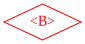

In [26]:
order  = n_proc.kernel_order()
order.view()

A cyclic dependence

In [27]:
cycle = Barrier('B', Barrier('C', Parallel(Synchro('B', Synchro('C', Prefix('a', Term()))),
                                           Synchro('C', Synchro('B', Prefix('b', Term()))))))
print(cycle)

nu(B)[nu(C)[(<B><C>a.0 || <C><B>b.0)]]


In [28]:
order = cycle.kernel_order()
order.view()

In [29]:
f3j2 = Barrier('B', Barrier('C', Prefix('f',
                                par(Prefix('a', Synchro('B', Prefix('j1', Synchro('C', Term())))),
                                    Prefix('b', Synchro('B', Term())),
                                    Prefix('c', Synchro('C', Prefix('j2', Term())))))))

print(f3j2)

nu(B)[nu(C)[f.((a.<B>j1.<C>0 || b.<B>0) || c.<C>j2.0)]]


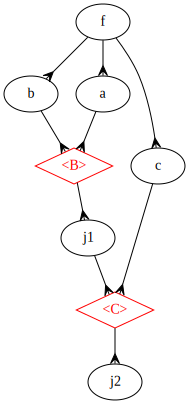

In [30]:
f3j2.causal_order().view()

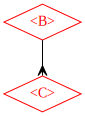

In [31]:
order = f3j2.kernel_order()
order.view()

In [32]:
cycle2 = Barrier('B', Barrier('C', Prefix('fork', 
            par(Prefix('start1', Synchro('C', Prefix('end1', Synchro('B', Term())))),
                Prefix('start2', Synchro('B', Prefix('end2', Term()))),
                Synchro('B', Prefix('start3', Synchro('C', Prefix('end3', Term()))))))))
print(cycle2)

nu(B)[nu(C)[fork.((start1.<C>end1.<B>0 || start2.<B>end2.0) || <B>start3.<C>end3.0)]]


In [33]:
order = cycle2.kernel_order()
order.view()

In [34]:
example = Barrier('B', Barrier('C', Prefix('fork', 
            par(Prefix('start1', Synchro('B', Prefix('end1', Synchro('C', Term())))),
                Synchro('B', Prefix('start2', Prefix('end2', Term()))),
                Synchro('B', Prefix('start3', Synchro('C', Prefix('end3', Term()))))))))
print(example)

nu(B)[nu(C)[fork.((start1.<B>end1.<C>0 || <B>start2.end2.0) || <B>start3.<C>end3.0)]]


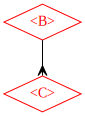

In [35]:
order = example.kernel_order()
order.view()

In [36]:
bodini = Prefix('a', Barrier('B', Barrier('C',
                     Parallel(Prefix('c',Synchro('B', Term())),
                              Prefix('b', Parallel(Synchro('B', Prefix('d', Synchro('C', Prefix('f', Term())))),
                                                   Prefix('e', Synchro('C', Term()))))))))
print(bodini)                             

a.nu(B)[nu(C)[(c.<B>0 || b.(<B>d.<C>f.0 || e.<C>0))]]


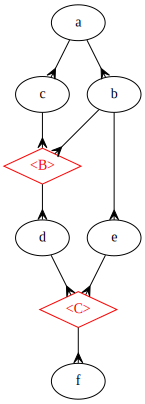

In [37]:
causal = bodini.causal_order()
causal.view()

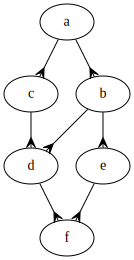

In [38]:
causal.join('syncB').join('syncC').view()

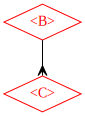

In [39]:
kernel = bodini.kernel_order()
kernel.view()